In [0]:
%%capture
!pip install --upgrade tensorflow-gpu==2.0.0 gensim mlflow scikit-optimize

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


In [3]:
import numpy as np
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics
import mlflow

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import seaborn as sb

import skopt
from skopt import gp_minimize
from skopt import dump, load
from skopt.space import Real, Integer, Categorical

sb.set_style('whitegrid')
sb.set_palette('colorblind')
sb.set_context('paper')

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_best(res):
    print("Best value: %.4f" % res.fun)
    param_names = {idx: param_name for param_name, idx in search_space_keys.items()}
    best_params = {param_names[i]: param_value for i, param_value in enumerate(res.x)}
    print("Best params:")
    print(best_params)

In [0]:
plt.style.use('default')

import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    output:
        the smoothed signal
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat':
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

def plot_history(history,w_len=3):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b', label='Training acc',alpha=0.4)
    plt.plot(smooth(np.array(acc),window_len=w_len),'b',lw=2)
    plt.plot(val_acc, 'r', label='Validation acc',alpha=0.4)
    plt.plot(smooth(np.array(val_acc),window_len=w_len),'r',lw=2)
    
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b', label='Training loss',alpha=0.4)
    plt.plot(smooth(np.array(loss),window_len=w_len),'b',lw=2)
    plt.plot(val_loss, 'r', label='Validation loss',alpha=0.4)
    plt.plot(smooth(np.array(val_loss),window_len=w_len),'r',lw=2)
    plt.title('Training and validation loss')
    plt.legend()

In [0]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def plot_exploration(res,search_space,host):
  
  A = res.x_iters
  B = res.func_vals
  N = np.array(1.0 - B,dtype=np.float)
  
  M = np.char.replace(A,'Adam','0')
  M = np.char.replace(M,'Nadam','1')
  M = np.array(M,dtype=np.float)
  M = np.append(M,N[:,None],axis=1)
  
  labels = list(search_space.keys())
  labels.append('Accuracy')
  M = pd.DataFrame(data=M,columns=labels)
  
  M["learning_rate"] = M["learning_rate"].apply(lambda x : np.log10(x))
  
  Mmin = pd.DataFrame(np.zeros((1,M.shape[1])),columns=labels)
  Mmax = pd.DataFrame(np.zeros((1,M.shape[1])),columns=labels)
  
  for i,key in enumerate(search_space.keys()):
    if type(search_space_vals[i]) != Categorical:
      Mmin[key] = search_space_vals[i].low
      Mmax[key] = search_space_vals[i].high
  
  Mmin['learning_rate'] = M["learning_rate"].min()
  Mmax['learning_rate'] = M["learning_rate"].max()
  
  Mmin['optimizer'] = 0.0
  Mmax['optimizer'] = 1.0
  
  Mmin['Accuracy'] = M["Accuracy"].min()
  Mmax['Accuracy'] = M["Accuracy"].max()
  
  for col in M.columns:
    M[col] = M[col].apply(lambda x: (x - Mmin[col]) / (Mmax[col] - Mmin[col]))
  
  color = M["Accuracy"].values.astype(np.float)
  nvars = len(labels)
  
  host.spines["top"].set_visible(False)
  host.spines["bottom"].set_visible(False)
  host.xaxis.set_visible(False)
  host.yaxis.set_visible(False)

  host.set_xlim(0, nvars-1)
  host.set_ylim(0-0.01, 1+0.01)
  
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='x', **tkw)
  
  par = []
  for i,var in enumerate(labels):
    par.append(host.twinx())
    par[i].spines["right"].set_position(("axes", i/(nvars-1)))
    make_patch_spines_invisible(par[i])
    par[i].spines["right"].set_visible(True)
    delta = (Mmax[var].values[0] - Mmin[var].values[0])*0.01
    par[i].set_ylim(Mmin[var].values[0] - delta, Mmax[var].values[0] + delta)
  
    par[i].set_ylabel(var)
    par[i].yaxis.label.set_color('k')
    par[i].tick_params(axis='y', colors='k', **tkw)
  
    if var == 'learning_rate':
      delta = (Mmax[var].values[0] - Mmin[var].values[0])*0.01
      par[i].set_ylim(10.0**(Mmin[var].values[0]-delta),10.0**(Mmax[var].values[0]+delta))
      par[i].semilogy()

    if var == 'optimizer':
      par[i].set_yticks([0.0,1.0],minor=False)
      par[i].set_yticklabels(["Adam","Nadam"])


  N = M.shape[0]
  for i in range(N):
    p1, = host.plot(M.iloc[i].values,c=plt.cm.rainbow_r(color[i]),alpha=0.1)
  
  i = np.argmax(M["Accuracy"].values)
  p1, = host.plot(M.iloc[i],c='m',lw=3.0,alpha=1.0)

## Carga de datos

In [0]:
DATA_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/PetFinder'

In [9]:
dataset = pd.read_csv(os.path.join(DATA_DIRECTORY, 'train.csv'))

dataset.head(3)

Type  Age  ...  AdoptionSpeed  PID
0     2    3  ...              2    0
1     1    4  ...              2    3
2     1    1  ...              2    4

[3 rows x 20 columns]

In [10]:
dataset.describe()

Type           Age  ...  AdoptionSpeed           PID
count  10582.000000  10582.000000  ...   10582.000000  10582.000000
mean       1.454734     10.520412  ...       2.518900   7477.025799
std        0.497970     18.374027  ...       1.176018   4310.921553
min        1.000000      0.000000  ...       0.000000      0.000000
25%        1.000000      2.000000  ...       2.000000   3768.250000
50%        1.000000      3.000000  ...       2.000000   7473.500000
75%        2.000000     12.000000  ...       4.000000  11200.750000
max        2.000000    255.000000  ...       4.000000  14992.000000

[8 rows x 19 columns]

In [11]:
dataset.dtypes

Type              int64
Age               int64
Breed1            int64
Breed2            int64
Gender            int64
Color1            int64
Color2            int64
Color3            int64
MaturitySize      int64
FurLength         int64
Vaccinated        int64
Dewormed          int64
Sterilized        int64
Health            int64
Quantity          int64
Fee               int64
State             int64
Description      object
AdoptionSpeed     int64
PID               int64
dtype: object

In [12]:
target_col = 'AdoptionSpeed'
nlabels = dataset[target_col].unique().shape[0]
print("Nlabels: %d" % nlabels)

Nlabels: 5


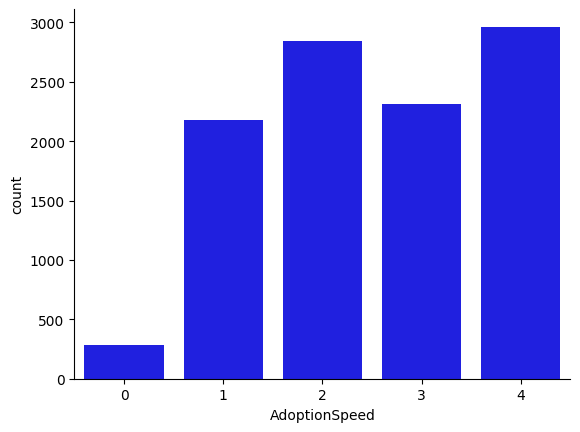

In [13]:
sb.countplot(dataset.AdoptionSpeed, color='blue')
sb.despine()

### Desbalance de clases

Calculo el peso relativo que debería darle a cada clase para balancear la muestra.

In [20]:
clases, cuentas = np.unique(dataset.AdoptionSpeed,return_counts=True)
class_weight = cuentas/cuentas.max()
print(1./class_weight)

[10.4         1.36150666  1.0414617   1.28311688  1.        ]


## Creación de los Datasets

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Type','Gender', 'Color1','MaturitySize','FurLength','Vaccinated','Health','Dewormed','Sterilized']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Fee','Age']

In [0]:
Scalers = {}

def process_features(df,test_data=False):

    if not test_data:
      for numeric_col in numeric_columns:
        Scalers[numeric_col] = preprocessing.MinMaxScaler().fit(df[numeric_col].values.reshape(-1,1))

    direct_features = []
    instance = {}

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))

    # Create and append numeric columns
    for numeric_col in numeric_columns:
        direct_features.append(Scalers[numeric_col].transform(df[numeric_col].values.reshape(-1,1)))

    # Concatenate all features that don't need further embedding into a single matrix.
    instance['direct_features'] =  np.hstack(direct_features)

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        instance[embedded_col] = df[embedded_col].values

    # Convert labels to one-hot encodings
    targets = tf.keras.utils.to_categorical(df[target_col], nlabels)
    return instance, targets

### Datos de entrenamiento y validación

Dividimos la base de datos en conjunto de entrenamiento (70%) y validación (30%)

In [0]:
def generate_dataset(df,BATCH_SIZE):

  train_dataset, test_dataset = train_test_split(df, test_size=0.3, shuffle = True)

  X_train, y_train = process_features(train_dataset)
  X_test, y_test = process_features(test_dataset,test_data=True)

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_dataset = train_dataset.shuffle(buffer_size=len(y_train)).batch(BATCH_SIZE)

  test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_SIZE)

  return(train_dataset,test_dataset)

## Modelo una capa

### Espacio de parámetros

In [17]:
from skopt.space import Real, Integer, Categorical

search_space = {
  "batch_size": Integer(500, 4000, name="batch_size"),
  "hidden_layer_size_1": Integer(10, 200, name="hidden_layer_size"),
  "dropout_1": Real(low=0.0,high=0.5,prior='uniform',name='dropout'),
  "learning_rate": Real(low=1e-5, high=1e-1, prior='log-uniform', name='learning_rate'),
  "optimizer": Categorical(["Adam","Nadam"],name="optimizer")
}

# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx
                     for idx, param_name in enumerate(search_space_keys)}
print(search_space)

def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

{'batch_size': Integer(low=500, high=4000), 'hidden_layer_size_1': Integer(low=10, high=200), 'dropout_1': Real(low=0.0, high=0.5, prior='uniform', transform='identity'), 'learning_rate': Real(low=1e-05, high=0.1, prior='log-uniform', transform='identity'), 'optimizer': Categorical(categories=('Adam', 'Nadam'), prior=None)}


### Constructor del modelo

In [0]:
def build_baseline_model(params):
    '''
    Funcion constructura del modelo
    '''
    
    tf.keras.backend.clear_session()

    # Define inputs

    # Add one input and one embedding for each embedded column
    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define embedding layer
        embedding_size = int(max_value/16)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim = max_value,output_dim = embedding_size)(input_layer),axis=-2))
    
    # Add input for direct feature columns
    direct_features_input = layers.Input(
        shape = (sum(one_hot_columns.values(), len(numeric_columns)),), 
        name = 'direct_features'
    )
    inputs.append(direct_features_input)

    # Concatenate everything together
    feature_map = layers.Concatenate(name="feature_map")(embedding_layers + [direct_features_input])

    # Define model
    HIDDEN_LAYER_SIZE_1 = hyperparam_value("hidden_layer_size_1", params)
    DROPOUT_1 = hyperparam_value("dropout_1", params)

    x = layers.Dense(HIDDEN_LAYER_SIZE_1, activation='relu',name="Layer1")(feature_map)
    x = Dropout(DROPOUT_1)(x)

    output_layer = layers.Dense(nlabels, activation='softmax')(x)

    # Define optimizer
    LEARNING_RATE = hyperparam_value("learning_rate", params)
    if hyperparam_value("optimizer",params) == "Nadam":
      optimizer = optimizers.Nadam(learning_rate=LEARNING_RATE)
    if hyperparam_value("optimizer",params) == "Adam":
      optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    
    # Build
    model = models.Model(inputs=inputs, outputs=output_layer, name="first_model")

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return(model)

### Función objetivo para minimizar

In [0]:
def objective_function(params):

    print_selected_hyperparams(params)

    tf.keras.backend.clear_session()

    # Define datasets
    BATCH_SIZE = hyperparam_value("batch_size", params)
    train_dataset, dev_dataset = generate_dataset(dataset,BATCH_SIZE)

    # Construct model with these parameters
    model = build_baseline_model(params)

    class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}

    earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Train
    epochs = 300

    history = model.fit(train_dataset, 
                        epochs = epochs, 
                        verbose=0,
                        class_weight = class_weight,
                        validation_data = dev_dataset, 
                        validation_freq = 1,
                        callbacks=[earlystopping])
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose = 0)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    
    return(1.0 - accuracy)

### Definiendo el modelo

In [0]:
params = {'batch_size': 4000, 
          'hidden_layer_size_1': 64, 
          'dropout_1': 0.2, 
          'learning_rate': 0.0001, 
          'optimizer': 'Adam'}

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_baseline_model(list(params.values()))

In [22]:
model.summary()

Model: "first_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 19)        5852        Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 19)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 33)]         0                                            
________________________________________________________________________________________

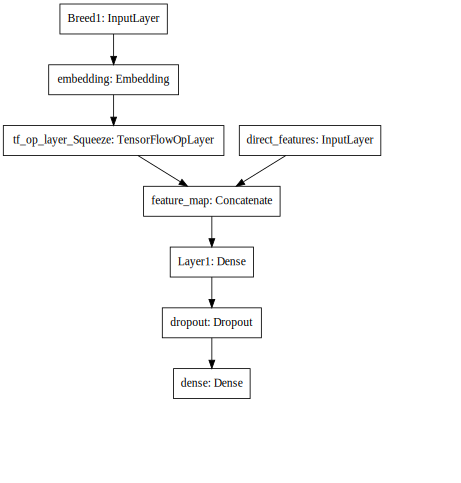

In [23]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

### Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente.

In [0]:
tf.keras.backend.clear_session()

class_weight = {0: 10., 1: 1.4, 2: 1., 3: 1.3, 4: 1.}

earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
epochs = 600
history = model.fit(train_dataset,
                    epochs = epochs,
                    class_weight = class_weight,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose = 0,
                    callbacks=[earlystopping]
                    )

In [25]:
# Evaluate
loss, accuracy = model.evaluate(dev_dataset, verbose = 1)
print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))

1/1 [==============================] - 0s 12ms/step - loss: 1.3859 - accuracy: 0.3701
*** Test loss: 1.3859429359436035 - accuracy: 0.3700787425041199


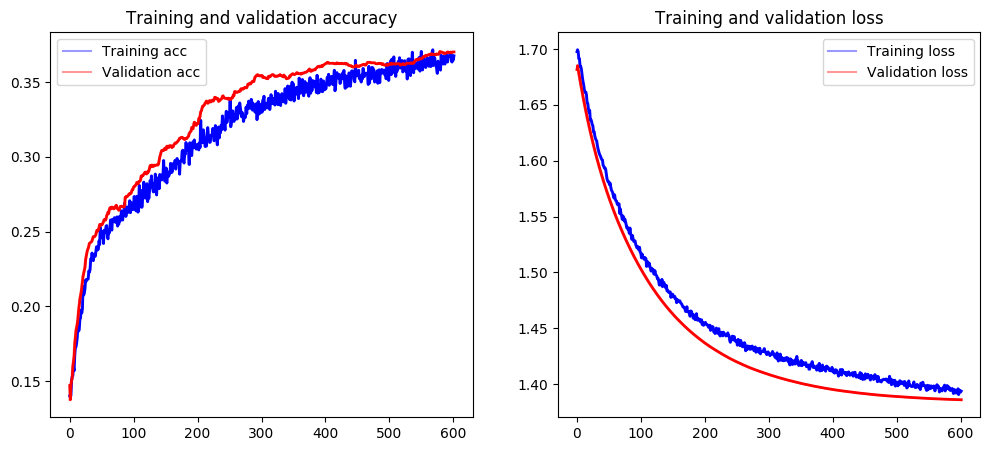

In [26]:
plot_history(history)

### Buscando mejores parámetros

In [0]:
iterations = 200
exploration_result = gp_minimize(objective_function,
                                 search_space_vals,
                                 random_state = 21,
                                 verbose = 0,
                                 n_calls = iterations)

In [0]:
dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_2.pkl')

In [0]:
exploration_result = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_2.pkl')

In [28]:
show_best(exploration_result)

Best value: 0.6211
Best params:
{'batch_size': 4000, 'hidden_layer_size_1': 103, 'dropout_1': 0.0, 'learning_rate': 0.1, 'optimizer': 'Adam'}


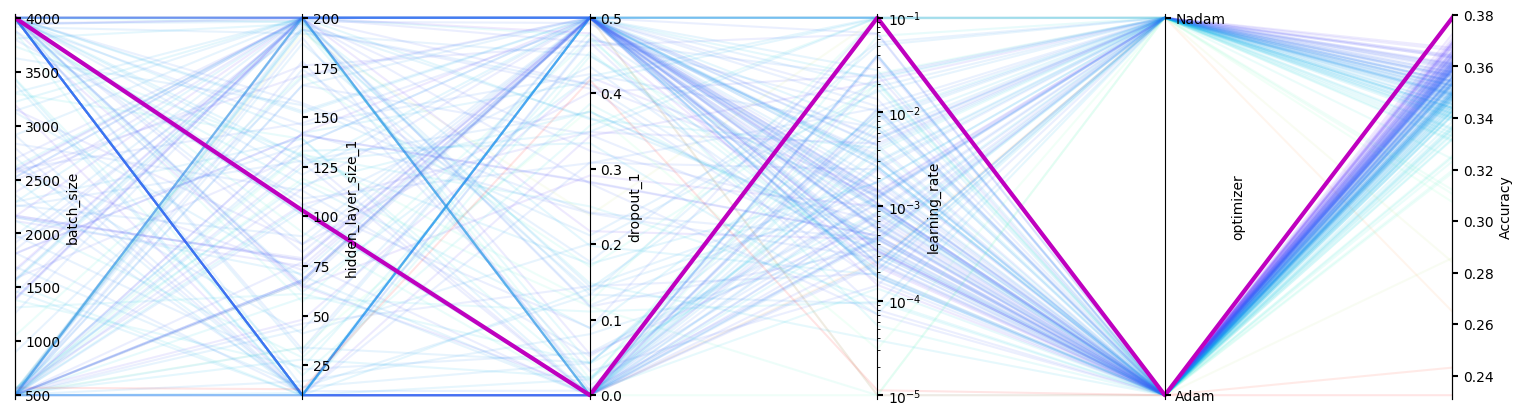

In [29]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(exploration_result,search_space,host)
plt.show()

### Entrenando mejor modelo

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,hyperparam_value('batch_size',best_params))
model = build_baseline_model(best_params)

In [0]:
tf.keras.backend.clear_session()

class_weight = {0: 10., 1: 1.4, 2: 1., 3: 1.3, 4: 1.}

earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train
epochs = 600
history = model.fit(train_dataset,
                    epochs = epochs,
                    class_weight = class_weight,
                    validation_data = dev_dataset,
                    validation_freq = 1,
                    verbose = 0,
                    callbacks=[earlystopping])
                    

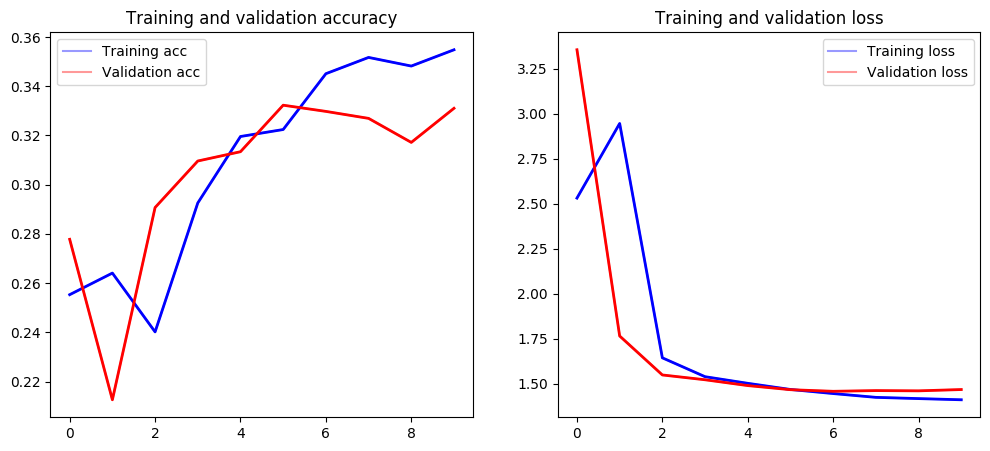

In [36]:
plot_history(history,w_len=2)

## Modelo dos capas


### Espacio de parámetros

In [0]:
search_space = {
  "batch_size": Integer(500, 4000, name="batch_size"),
  "hidden_layer_size_1": Integer(10, 200, name="hidden_layer_size"),
  "dropout_1": Real(low=0.0,high=0.5,prior='uniform',name='dropout'),
  "hidden_layer_size_2": Integer(10, 200, name="hidden_layer_size"),
  "dropout_2": Real(low=0.0,high=0.5,prior='uniform',name='dropout'),
  "learning_rate": Real(low=1e-5, high=1e-1, prior='log-uniform', name='learning_rate'),
  "optimizer": Categorical(["Adam","Nadam"],name="optimizer")
}

# Unzipping
search_space_keys, search_space_vals = zip(*search_space.items())
search_space_keys = {param_name: idx
                     for idx, param_name in enumerate(search_space_keys)}
                     
def hyperparam_value(param_name, param_list):
    return param_list[search_space_keys[param_name]]

def print_selected_hyperparams(param_values):
    for param_name in search_space_keys:
        print("\t", param_name, hyperparam_value(param_name, param_values))

### Constructor del modelo

In [0]:
def build_model(params):
    '''
    Funcion constructura del modelo
    '''
    
    tf.keras.backend.clear_session()

    # Define inputs

    # Add one input and one embedding for each embedded column
    embedding_layers = []
    inputs = []

    for embedded_col, max_value in embedded_columns.items():
        input_layer = layers.Input(shape=(1,), name=embedded_col)
        inputs.append(input_layer)
        # Define embedding layer
        embedding_size = int(max_value/16)
        embedding_layers.append(
            tf.squeeze(layers.Embedding(input_dim = max_value,output_dim = embedding_size)(input_layer),axis=-2))
    
    # Add input for direct feature columns
    direct_features_input = layers.Input(
        shape = (sum(one_hot_columns.values(), len(numeric_columns)),), 
        name = 'direct_features'
    )
    inputs.append(direct_features_input)

    # Concatenate everything together
    feature_map = layers.Concatenate(name="feature_map")(embedding_layers + [direct_features_input])

    # Define model
    HIDDEN_LAYER_SIZE_1 = hyperparam_value("hidden_layer_size_1", params)
    DROPOUT_1 = hyperparam_value("dropout_1", params)

    x = layers.Dense(HIDDEN_LAYER_SIZE_1, activation='relu',name="Layer1")(feature_map)
    x = Dropout(DROPOUT_1)(x)

    HIDDEN_LAYER_SIZE_2 = hyperparam_value("hidden_layer_size_2", params)
    DROPOUT_2 = hyperparam_value("dropout_2", params)

    x = layers.Dense(HIDDEN_LAYER_SIZE_2, activation='relu',name="Layer2")(x)
    x = Dropout(DROPOUT_2)(x)

    output_layer = layers.Dense(nlabels, activation='softmax')(x)

    # Define optimizer
    LEARNING_RATE = hyperparam_value("learning_rate", params)
    if hyperparam_value("optimizer",params) == "Nadam":
      optimizer = optimizers.Nadam(learning_rate=LEARNING_RATE)
    if hyperparam_value("optimizer",params) == "Adam":
      optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    
    # Build
    model = models.Model(inputs=inputs, outputs=output_layer, name="Two_Layers_Model")

    # Compile the model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return(model)

### Función objetivo para minimizar

In [0]:
def objective_function(params):

    print_selected_hyperparams(params)

    tf.keras.backend.clear_session()

    # Define datasets
    BATCH_SIZE = hyperparam_value("batch_size", params)
    train_dataset, dev_dataset = generate_dataset(dataset,BATCH_SIZE)

    # Construct model with these parameters
    model = build_model(params)

    class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}

    earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

    # Train
    epochs = 300
    history = model.fit(train_dataset, 
                        epochs = epochs, 
                        verbose=0,
                        class_weight = class_weight,
                        validation_data = dev_dataset, 
                        validation_freq = 1,
                        callbacks=[earlystopping])

    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose = 0)
    print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))
    
    return(1.0 - accuracy)

### Definiendo modelo

In [0]:
params = {'batch_size': 4000, 
          'hidden_layer_size_1': 128, 
          'dropout_1': 0.2, 
          'hidden_layer_size_2': 64, 
          'dropout_2': 0.3, 
          'learning_rate': 0.0001, 
          'optimizer': 'Adam'}

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_model(list(params.values()))

In [41]:
model.summary()

Model: "Two_Layers_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 19)        5852        Breed1[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Squeeze (TensorFlow [(None, 19)]         0           embedding[0][0]                  
__________________________________________________________________________________________________
direct_features (InputLayer)    [(None, 33)]         0                                            
___________________________________________________________________________________

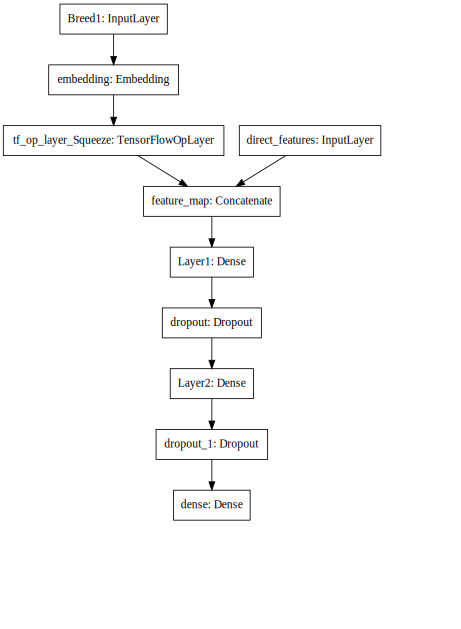

In [42]:
SVG(tf.keras.utils.model_to_dot(model, dpi=60).create(prog='dot', format='svg'))

### Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente.

In [0]:
tf.keras.backend.clear_session()

class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}

earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train
epochs = 300
history = model.fit(train_dataset, 
                    epochs = epochs, 
                    verbose=0,
                    class_weight = class_weight,
                    validation_data = dev_dataset, 
                    validation_freq = 1,
                    callbacks=[earlystopping])

In [45]:
# Evaluate
loss, accuracy = model.evaluate(dev_dataset, verbose = 1)
print("*** Test loss: {} - accuracy: {}".format(loss, accuracy))

1/1 [==============================] - 0s 16ms/step - loss: 1.4014 - accuracy: 0.3540
*** Test loss: 1.4013522863388062 - accuracy: 0.3540157377719879


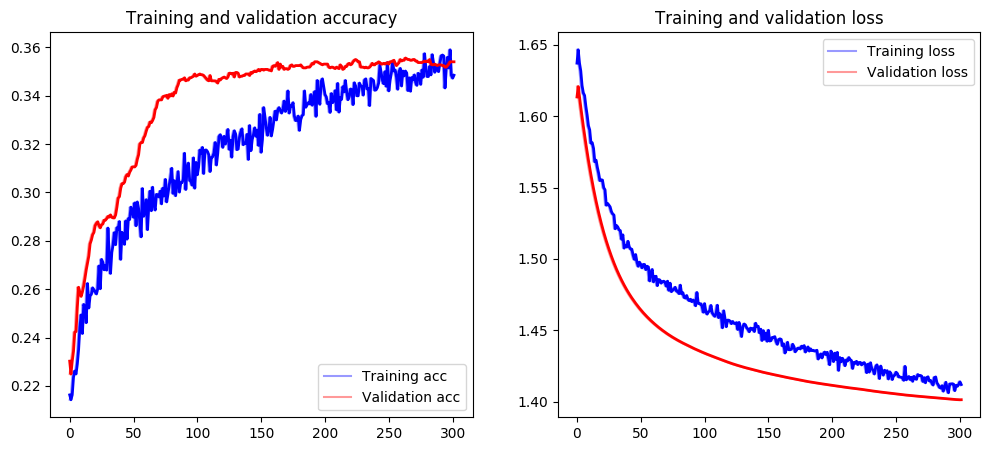

In [46]:
plot_history(history)

### Buscando mejores parámetros

In [0]:
iterations = 200
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state = 21, verbose = 0, n_calls = iterations)

In [0]:
from skopt import dump, load
dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_1.pkl')

In [0]:
exploration_result = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_1.pkl')

In [48]:
show_best(exploration_result)

Best value: 0.6265
Best params:
{'batch_size': 2111, 'hidden_layer_size_1': 10, 'dropout_1': 0.5, 'hidden_layer_size_2': 200, 'dropout_2': 0.5, 'learning_rate': 0.008067009715798032, 'optimizer': 'Adam'}


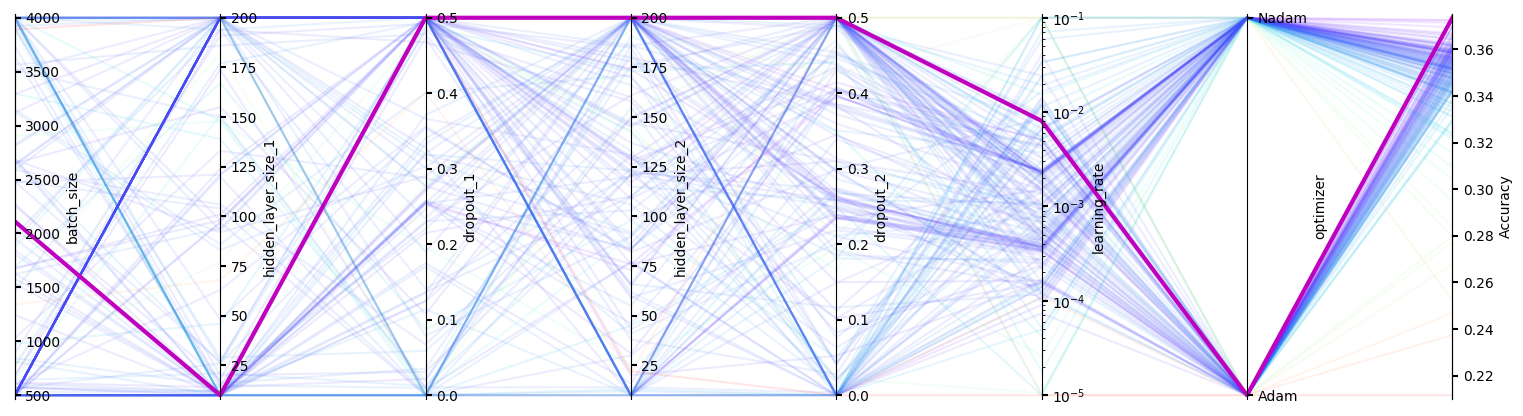

In [49]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(exploration_result,search_space,host)
plt.show()

### Entrenando mejor modelo

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_baseline_model(best_params)

In [0]:
tf.keras.backend.clear_session()

class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}

earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train
epochs = 300
history = model.fit(train_dataset, 
                    epochs = epochs, 
                    verbose=0,
                    class_weight = class_weight,
                    validation_data = dev_dataset, 
                    validation_freq = 1,
                    callbacks=[earlystopping])

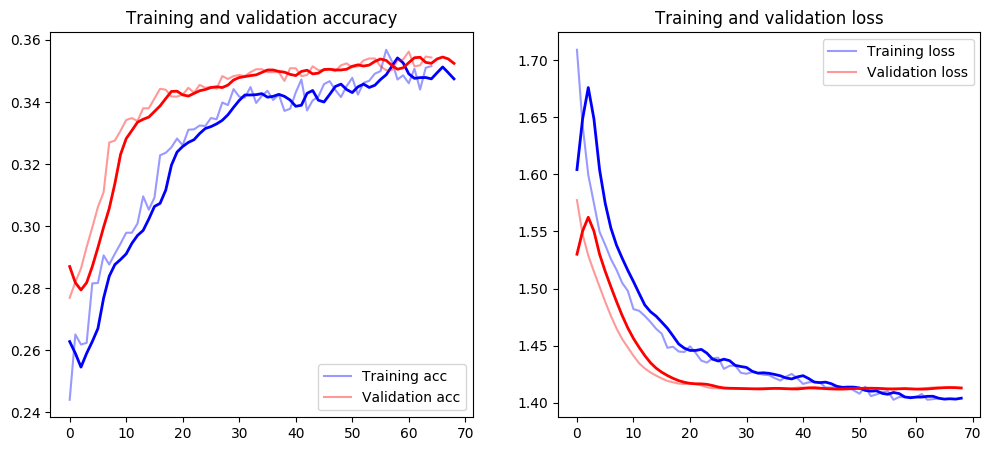

In [53]:
plot_history(history,w_len=5)

### Cambiando el conjunto de variables

In [0]:
def plotter(history,w_len=3,title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f = plt.figure(figsize=(6,3))
    f.suptitle(title,fontsize=9)

    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b', label='Training acc',alpha=0.4)
    plt.plot(smooth(np.array(acc),window_len=w_len),'b',lw=2)
    plt.plot(val_acc, 'r', label='Validation acc',alpha=0.4)
    plt.plot(smooth(np.array(val_acc),window_len=w_len),'r',lw=2)
    plt.title('Training and validation accuracy',fontsize=7)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b', label='Training loss',alpha=0.4)
    plt.plot(smooth(np.array(loss),window_len=w_len),'b',lw=2)
    plt.plot(val_loss, 'r', label='Validation loss',alpha=0.4)
    plt.plot(smooth(np.array(val_loss),window_len=w_len),'r',lw=2)
    plt.title('Training and validation loss',fontsize=7)
    plt.legend()
    plt.show()

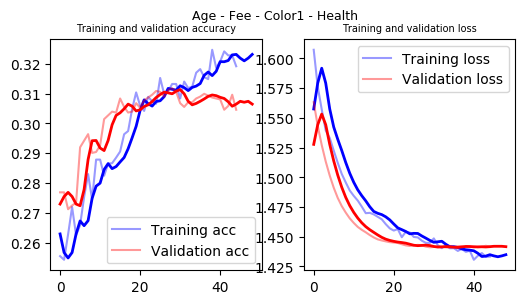

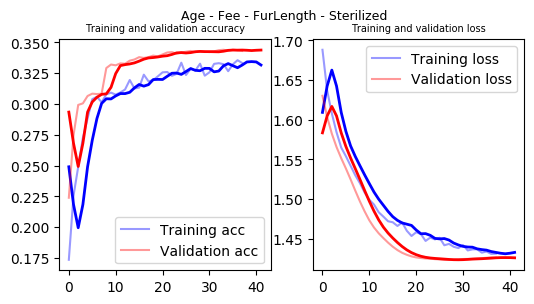

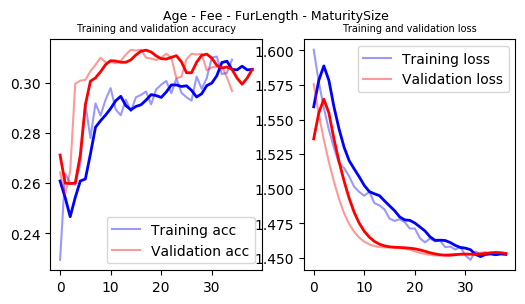

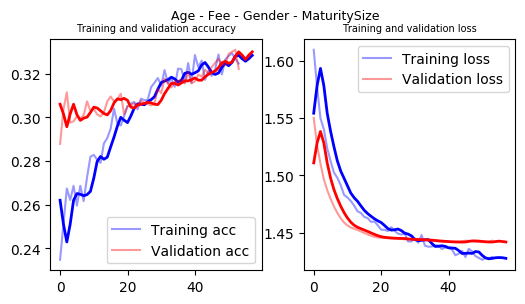

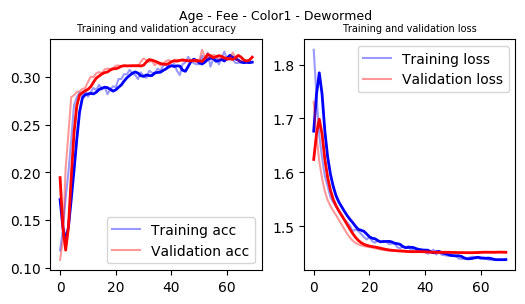

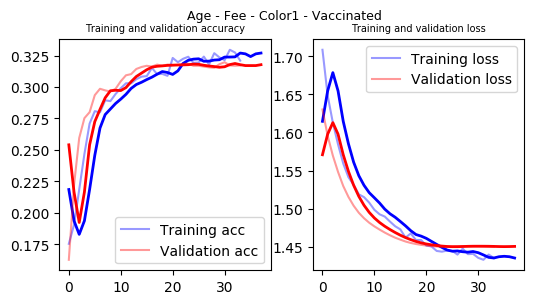

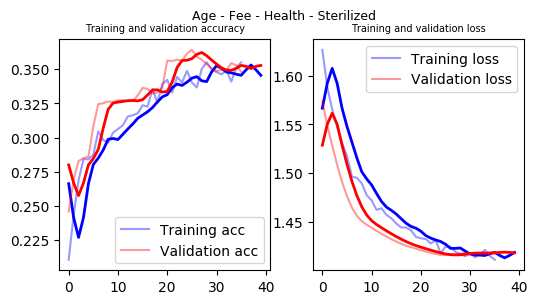

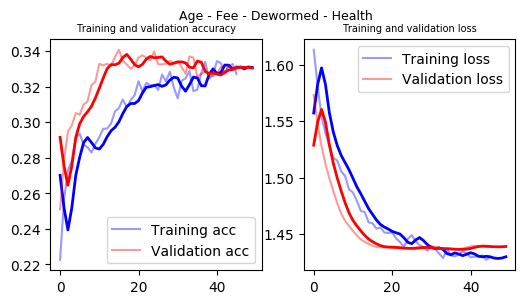

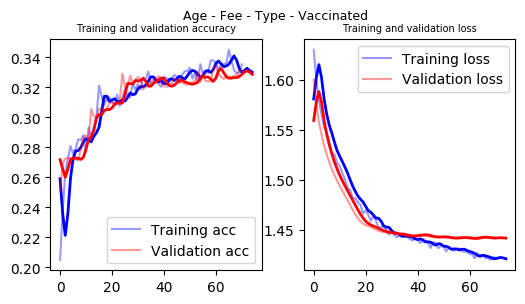

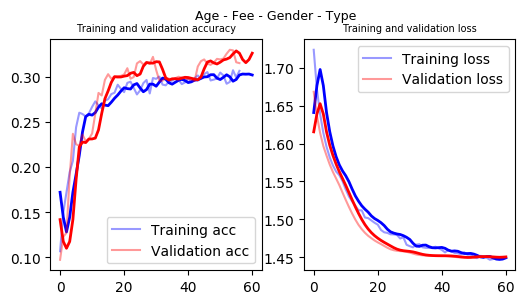

In [68]:
vv = []

for i in range(10):

  OHcolumns = ['Type','Gender','Color1','MaturitySize','FurLength','Vaccinated','Health','Dewormed','Sterilized']
  Ncolumns = ['Fee','Age']

  #N_OH = int(np.random.rand()*(len(OHcolumns)+1))
  #N_Num = int(np.random.rand()*(len(Ncolumns)+1))
  N_OH = 2
  N_Num = 2

  if (N_OH == 0) & (N_Num == 0):
    continue

  _OHcolumns = np.random.choice(OHcolumns,size=N_OH,replace=False)
  _Ncolumns = np.random.choice(Ncolumns,size=N_Num,replace=False)

  _OHcolumns = np.sort(_OHcolumns)
  _Ncolumns = np.sort(_Ncolumns)

  title = ' - '.join(np.append(_Ncolumns,_OHcolumns))
  if title in vv:
    continue
  vv.append(title)

  # It's important to always use the same one-hot length
  one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in _OHcolumns
  }

  embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
  }

  numeric_columns = _Ncolumns

  best_params = exploration_result.x

  train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
  model = build_baseline_model(best_params)

  tf.keras.backend.clear_session()

  class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}
  earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
  # Train
  epochs = 100
  history = model.fit(train_dataset, 
                    epochs = epochs, 
                    verbose=0,
                    class_weight = class_weight,
                    validation_data = dev_dataset, 
                    validation_freq = 1,
                    callbacks=[earlystopping])
  
  plotter(history,w_len=5,title=title)

In [0]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender','Sterilized']
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1']
}
numeric_columns = ['Fee','Age']

In [0]:
best_params = exploration_result.x

train_dataset, dev_dataset = generate_dataset(dataset,params['batch_size'])
model = build_baseline_model(best_params)

In [0]:
tf.keras.backend.clear_session()
class_weight = {0: 10., 1: 1., 2: 1., 3: 1., 4: 1.}

earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train
epochs = 300
history = model.fit(train_dataset, 
                    epochs = epochs, 
                    verbose=0,
                    class_weight = class_weight,
                    validation_data = dev_dataset, 
                    validation_freq = 1,
                    callbacks=[earlystopping])

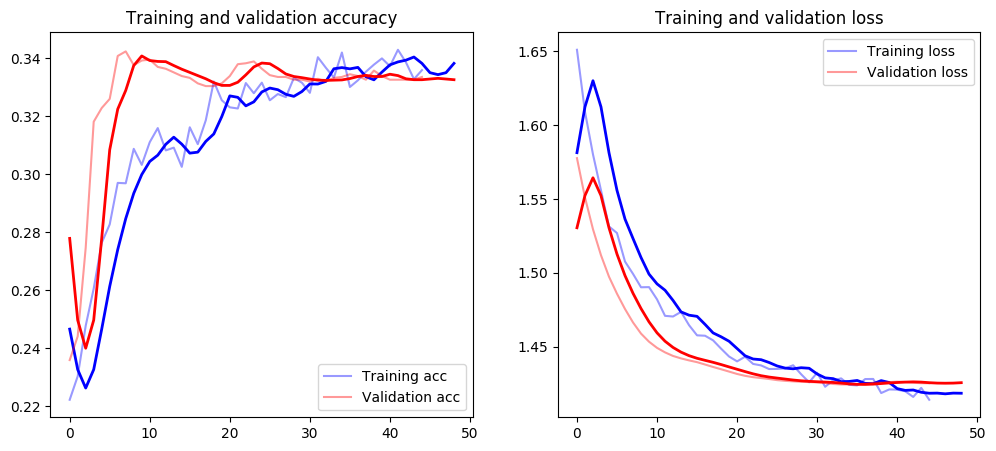

In [72]:
plot_history(history,w_len=5)

### Buscando mejores parámetros

In [76]:
iterations = 200
exploration_result = gp_minimize(
    objective_function, search_space_vals,
    random_state = 21, verbose = 0, n_calls = iterations)

	 batch_size 3297
	 hidden_layer_size_1 139
	 dropout_1 0.018073838284672187
	 hidden_layer_size_2 191
	 dropout_2 0.34883649293621355
	 learning_rate 4.2389382284283524e-05
	 optimizer Nadam
*** Test loss: 1.4172388315200806 - accuracy: 0.3436220586299896
	 batch_size 1691
	 hidden_layer_size_1 167
	 dropout_1 0.08734038125563766
	 hidden_layer_size_2 98
	 dropout_2 0.04928234641716074
	 learning_rate 0.012191001913888899
	 optimizer Adam
*** Test loss: 1.44840407371521 - accuracy: 0.3423621952533722
	 batch_size 1990
	 hidden_layer_size_1 194
	 dropout_1 0.1410208566877437
	 hidden_layer_size_2 121
	 dropout_2 0.24973848605249094
	 learning_rate 0.00014596780977344117
	 optimizer Nadam
*** Test loss: 1.3863736391067505 - accuracy: 0.3565354347229004
	 batch_size 3565
	 hidden_layer_size_1 186
	 dropout_1 0.478476524029538
	 hidden_layer_size_2 66
	 dropout_2 0.11629658384870192
	 learning_rate 0.00011691747926045541
	 optimizer Adam
*** Test loss: 1.4032529592514038 - accuracy: 0.354

In [0]:
from skopt import dump, load
dump(exploration_result, '/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_3.pkl')

In [0]:
exploration_result = load('/content/drive/My Drive/Colab Notebooks/AprendizajeProfundo/Exploration_Results_P1_3.pkl')

In [80]:
show_best(exploration_result)

Best value: 0.6227
Best params:
{'batch_size': 500, 'hidden_layer_size_1': 126, 'dropout_1': 0.5, 'hidden_layer_size_2': 200, 'dropout_2': 0.26789898933019857, 'learning_rate': 0.0002706048194218649, 'optimizer': 'Adam'}


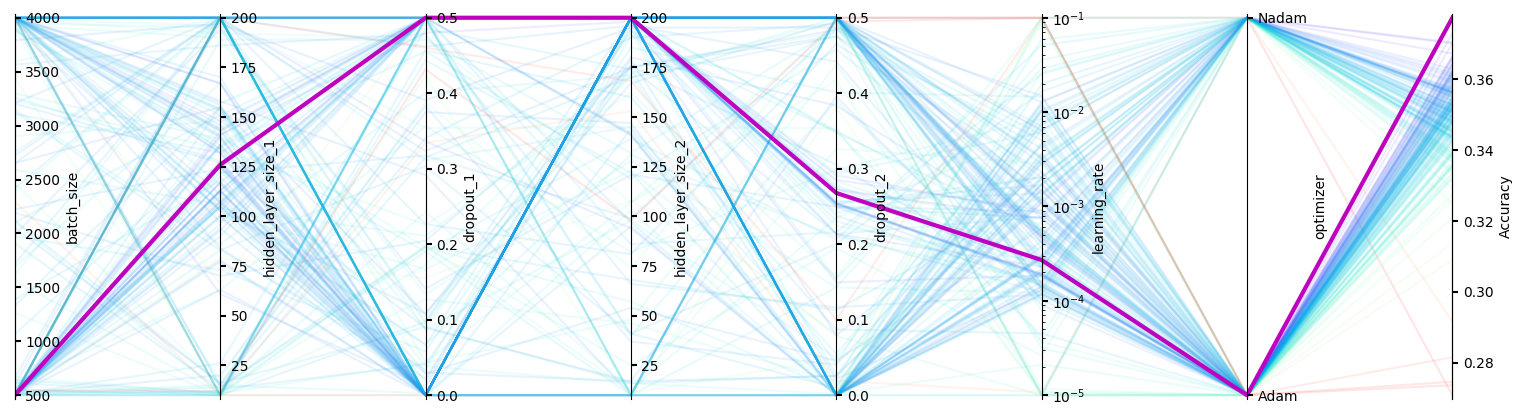

In [81]:
fig, host = plt.subplots(figsize=(23,5))
fig.subplots_adjust(right=0.75)
plot_exploration(exploration_result,search_space,host)
plt.show()